In [1]:
from pruning import PrunableLLM

/Users/jakubszafranski/anaconda3/envs/llm_pruning/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import numpy as np

sigmoid = lambda x: round(float(1 / (1 + np.exp(-x))), 2)
sigmoid(-2.5)

0.08

In [14]:
from datasets import load_dataset
import re

ds = load_dataset("EleutherAI/wikitext_document_level", "wikitext-2-raw-v1", split="train")
empty = 0
short = 0
for item in ds:
    text = item.get("page", "") or ""
    if not text.strip():
        empty += 1
    elif len(re.split(r"\s+", text.strip())) < 35:
        short += 1
print("total:", len(ds), "empty:", empty, "short(<100 words):", short)

total: 629 empty: 0 short(<100 words): 19


In [19]:
import matplotlib.pyplot as plt
import numpy as np

In [20]:
def quadratic_curve(a, b, c, i):
    t = i / 31
    return np.clip(a * t**2 + b * t + c, 0, 1)

def bezier_curve(P0, P1, P2, i):
    t = i / 31
    return (1 - t)**2 * P0 + 2 * (1 - t) * t * P1 + t**2 * P2

In [21]:
import numpy as np
from scipy.interpolate import CubicSpline

class PruningCurveParametrization:
    def __init__(self, num_layers=32, num_control_points=8):
        self.num_layers = num_layers
        self.num_control_points = num_control_points
        
        # Fixed x-coordinates for the control points (evenly spaced)
        # We add boundary points to ensure the curve covers the whole model
        self.x_control = np.linspace(0, num_layers - 1, num_control_points)
        
        # The x-coordinates we want to query (the actual layers)
        self.x_query = np.arange(num_layers)

    def get_layer_ratios(self, action_vector):
        """
        Args:
            action_vector (np.array): Shape (num_control_points,). 
                                      Values should be in [0, 1].
        Returns:
            np.array: Shape (32,). Pruning ratios for each layer.
        """
        # 1. Interpret action vector as Y-values (heights) for control points
        y_control = action_vector
        
        # 2. Create the Spline function
        # bc_type='clamped' ensures the slope at ends is 0 (stable)
        cs = CubicSpline(self.x_control, y_control, bc_type='clamped')
        
        # 3. Evaluate at every layer index (0, 1, 2... 31)
        layer_ratios = cs(self.x_query)
        
        # 4. CRITICAL: Clamp outputs. Splines can overshoot below 0 or above 1.
        layer_ratios = np.clip(layer_ratios, 0.0, 1.0)
        
        return layer_ratios

In [22]:
def mixture_of_gaussians(action_vector, num_layers=32, num_blobs=3):
    """
    action_vector: shape (num_blobs * 3,) - for each blob: mu, sigma, A
    """
    ratios = np.zeros(num_layers)
    for i in range(num_blobs):
        mu = action_vector[i*3] * (num_layers - 1)  # scale to 0-31
        sigma = action_vector[i*3 + 1] * 10 + 0.1  # scale to 0.1-10.1
        A = action_vector[i*3 + 2]  # 0-1
        for layer in range(num_layers):
            ratios[layer] += A * np.exp(-0.5 * ((layer - mu) / sigma)**2)
    return np.clip(ratios, 0, 1)

def dct_pruning(action_vector, num_layers=32):
    """
    action_vector: coefficients for DCT, length 8
    """
    from scipy.fft import dct, idct
    # Pad to 32
    coeffs = np.zeros(num_layers)
    coeffs[:len(action_vector)] = action_vector
    # Inverse DCT
    ratios = idct(coeffs, norm='ortho')
    # Shift and scale to 0-1
    ratios = (ratios - ratios.min()) / (ratios.max() - ratios.min())
    return ratios

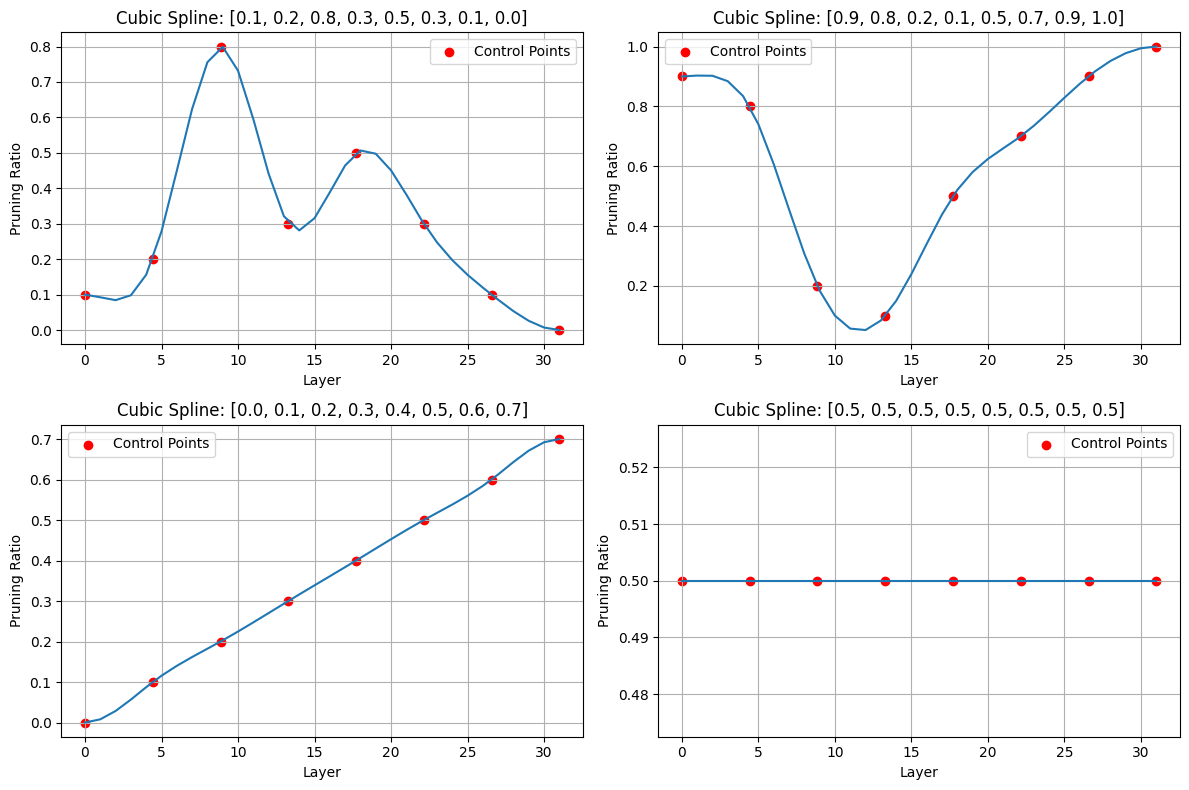

In [26]:
# Cubic B-Splines Visualization
curve_gen = PruningCurveParametrization(num_layers=32, num_control_points=8)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
actions = [
    [0.1, 0.2, 0.8, 0.3, 0.5, 0.3, 0.1, 0.0],  # U-shape
    [0.9, 0.8, 0.2, 0.1, 0.5, 0.7, 0.9, 1.0],  # Inverted U
    [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],  # Linear increase
    [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],  # Flat
]

for ax, action in zip(axes.flatten(), actions):
    ratios = curve_gen.get_layer_ratios(np.array(action))
    ax.plot(range(32), ratios)
    ax.scatter(curve_gen.x_control, action, color='red', label='Control Points')
    ax.set_title(f'Cubic Spline: {action}')
    ax.set_xlabel('Layer')
    ax.set_ylabel('Pruning Ratio')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

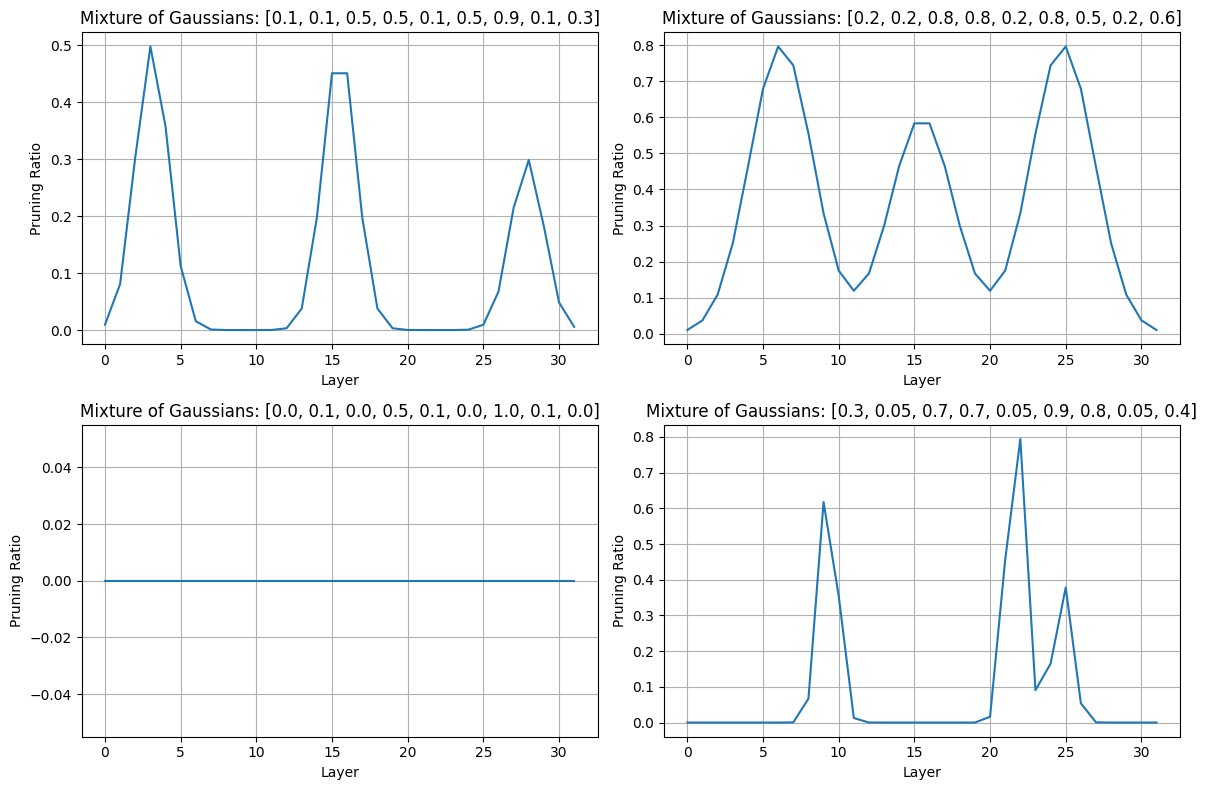

In [24]:
# Mixture of Gaussians Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
actions_gauss = [
    [0.1, 0.1, 0.5, 0.5, 0.1, 0.5, 0.9, 0.1, 0.3],  # Blob at start, middle, end
    [0.2, 0.2, 0.8, 0.8, 0.2, 0.8, 0.5, 0.2, 0.6],  # Different
    [0.0, 0.1, 0.0, 0.5, 0.1, 0.0, 1.0, 0.1, 0.0],  # One blob
    [0.3, 0.05, 0.7, 0.7, 0.05, 0.9, 0.8, 0.05, 0.4],  # Narrow blobs
]

for ax, action in zip(axes.flatten(), actions_gauss):
    ratios = mixture_of_gaussians(np.array(action))
    ax.plot(range(32), ratios)
    ax.set_title(f'Mixture of Gaussians: {action}')
    ax.set_xlabel('Layer')
    ax.set_ylabel('Pruning Ratio')
    ax.grid(True)

plt.tight_layout()
plt.show()

/var/folders/xb/43k6ccp53tgc4ldcm2nx6nkc0000gn/T/ipykernel_42681/1805255250.py:25: RuntimeWarning: invalid value encountered in divide
  ratios = (ratios - ratios.min()) / (ratios.max() - ratios.min())


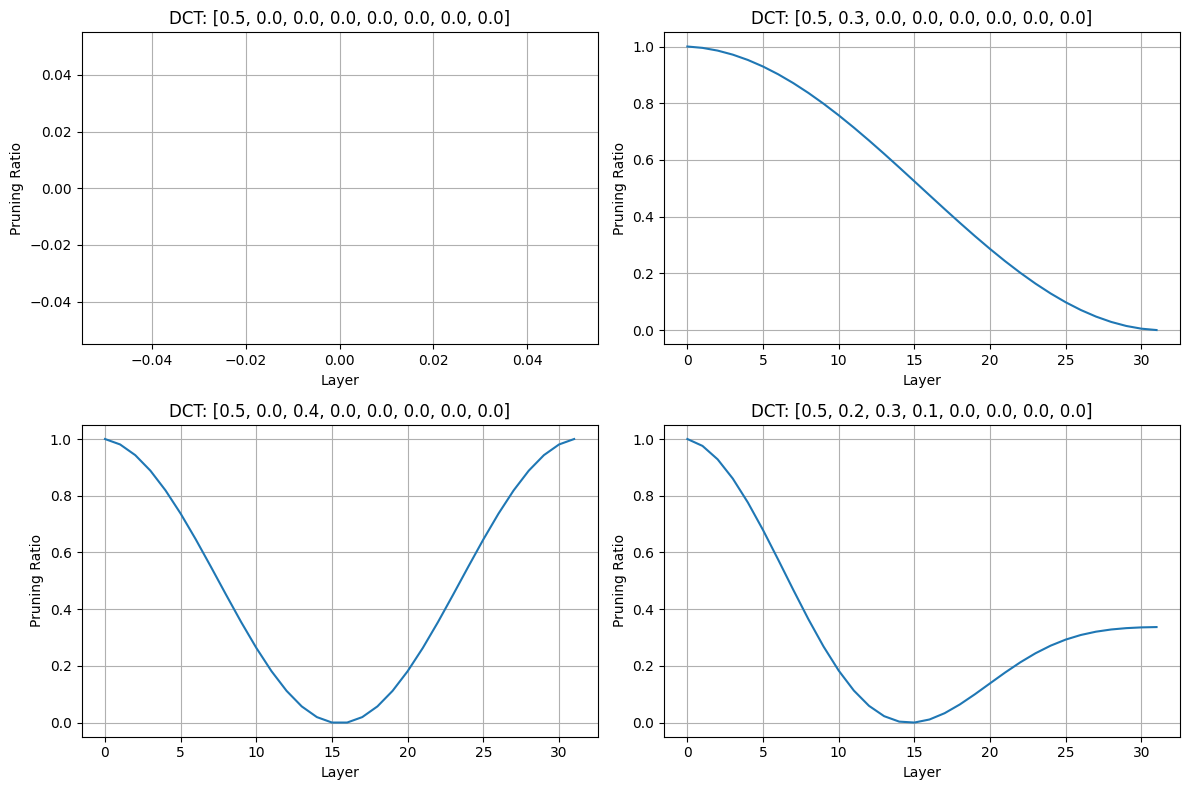

In [25]:
# DCT Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
actions_dct = [
    [0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # Constant
    [0.5, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # Slope
    [0.5, 0.0, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0],  # Hump
    [0.5, 0.2, 0.3, 0.1, 0.0, 0.0, 0.0, 0.0],  # Complex
]

for ax, action in zip(axes.flatten(), actions_dct):
    ratios = dct_pruning(np.array(action))
    ax.plot(range(32), ratios)
    ax.set_title(f'DCT: {action}')
    ax.set_xlabel('Layer')
    ax.set_ylabel('Pruning Ratio')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [7]:
import numpy as np
from scipy.interpolate import CubicSpline
def get_layer_ratios(action_vector, num_layers=32, num_control_points=8):
    """
    Convert 8 control point actions to 32 layer pruning ratios using cubic spline.
    
    Args:
        action_vector (np.array): Shape (num_control_points,). Values in [0, 1].
    Returns:
        np.array: Shape (num_layers,). Pruning ratios for each layer.
    """
    x_control = np.linspace(0, num_layers - 1, num_control_points)
    x_query = np.arange(num_layers)
    cs = CubicSpline(x_control, action_vector, bc_type='clamped')
    layer_ratios = cs(x_query)
    layer_ratios = np.clip(layer_ratios, 0.0, 1.0)
    return layer_ratios

av = np.array([0.1, 0.5, 0.9, 0.3, 0.6, 0.2, 0.4, 0.0])
lr = get_layer_ratios(av)
print(lr)

[0.1        0.12553626 0.19614739 0.30283693 0.43660842 0.58786584
 0.73694268 0.85581626 0.91621095 0.88989064 0.76868578 0.5970818
 0.42809638 0.3147472  0.30364046 0.37839615 0.48688392 0.57656309
 0.59527842 0.52445657 0.40468997 0.28259366 0.20478265 0.20834942
 0.27161992 0.35052448 0.40094933 0.37997533 0.28414989 0.15758385
 0.04721971 0.        ]


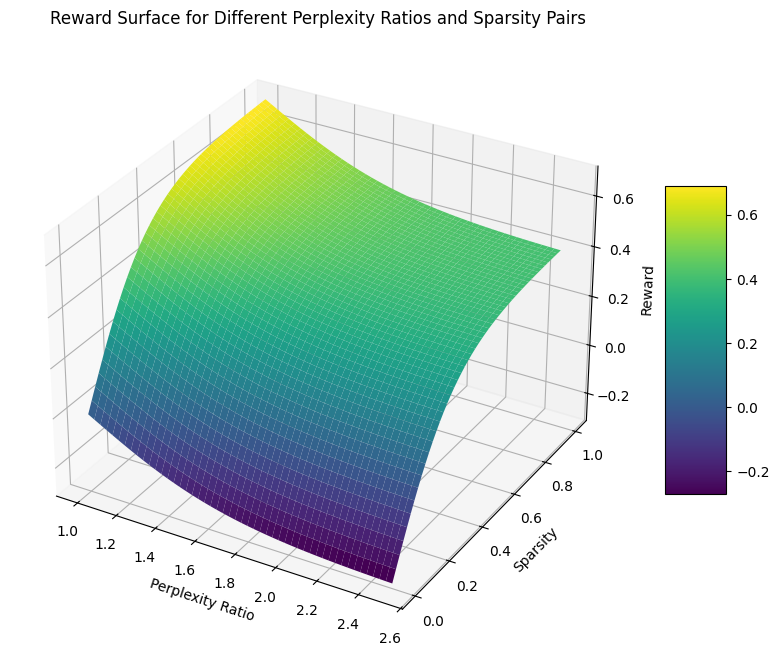

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from rl.reward import PerplexityReward

# Create reward calculator
reward_calc = PerplexityReward(quality_weight=0.3, ppl_sensitivity=1.5, sparsity_sensitivity=3.0)

# Assume baseline perplexity
baseline_ppl = 10.0

# Vary perplexity ratio and sparsity
ratios = np.linspace(1.0, 2.5, 50)
sparsities = np.linspace(0, 1, 50)

RR, SS = np.meshgrid(ratios, sparsities)
rewards = np.zeros_like(RR)

for i in range(RR.shape[0]):
    for j in range(RR.shape[1]):
        pruned_ppl = RR[i, j] * baseline_ppl
        rewards[i, j] = reward_calc.compute_reward(pruned_ppl, baseline_ppl, SS[i, j])

# Plot 3D surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(RR, SS, rewards, cmap='viridis', edgecolor='none')
ax.set_xlabel('Perplexity Ratio')
ax.set_ylabel('Sparsity')
ax.set_zlabel('Reward')
ax.set_title('Reward Surface for Different Perplexity Ratios and Sparsity Pairs')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()

In [131]:
new = 11.06 
new / 7.28

1.5192307692307692

In [128]:
import torch
import torch.nn as nn
from torch.nn import functional as F


class RNN(nn.Module):
    def __init__(self, input: int, hidden: int, output: int):
        super().__init__()
        self.fc_i = nn.Linear(input, hidden)
        self.fc_h = nn.Linear(hidden, hidden)
        self.fc_o = nn.Linear(hidden, output)
        self.relu = nn.ReLU()
        self.hidden = hidden

    def forward(self, x):
        n = x.shape[0]
        seq_len = x.shape[1]
        device = x.device
        dtype = x.dtype

        h = torch.zeros(n, self.hidden, device=device, dtype=dtype)
        for token_idx in range(seq_len):
            token = x[:, token_idx, :]
            h = self.fc_i(token) + self.fc_h(h)
            h = self.relu(h)
        
        y = self.fc_o(h)
        return y

rnn = RNN(3, 5, 3)

In [129]:
logits = rnn(x)
output = torch.softmax(logits, dim=-1)
output

tensor([[0.2358, 0.4383, 0.3258],
        [0.2558, 0.4310, 0.3133]], grad_fn=<SoftmaxBackward0>)

In [81]:
x = torch.tensor([[[1, 1, 1],
                  [2, 2, 2],
                  [3, 3, 3]],
                  [[2, 1, 1],
                  [3, 2, 2],
                  [4, 3, 3]]], dtype=torch.float32)
x

tensor([[[1., 1., 1.],
         [2., 2., 2.],
         [3., 3., 3.]],

        [[2., 1., 1.],
         [3., 2., 2.],
         [4., 3., 3.]]])